In [53]:
import spatialdata
import spatialdata_plot
import napari
import napari_spatialdata

import sopa.segmentation
import sopa.io

import ray

import matplotlib.pyplot as plt
import math

In [4]:
path_to_image = "/Users/jnimoca/Jose_BI/P26_SOPA_seg/991_subset.ome.tif"

In [5]:
sdata = sopa.io.ome_tif(path_to_image, as_image=False)

INFO     `dims` is specified redundantly: found also inside `data`.                                                


In [6]:
patches = sopa.segmentation.Patches2D(sdata, element_name="991_subset", patch_width=1200, patch_overlap=100)
patches.write()

[INFO] (sopa.patches.patches) 64 patches were saved in sdata['sopa_patches']


,geometry,bboxes,ilocs
0,"POLYGON ((1200 0, 1200 1200, 0 1200, 0 0, 1200...","[0, 0, 1200, 1200]","[0, 0]"
1,"POLYGON ((2300 0, 2300 1200, 1100 1200, 1100 0...","[1100, 0, 2300, 1200]","[1, 0]"
2,"POLYGON ((3400 0, 3400 1200, 2200 1200, 2200 0...","[2200, 0, 3400, 1200]","[2, 0]"
3,"POLYGON ((4500 0, 4500 1200, 3300 1200, 3300 0...","[3300, 0, 4500, 1200]","[3, 0]"
4,"POLYGON ((5600 0, 5600 1200, 4400 1200, 4400 0...","[4400, 0, 5600, 1200]","[4, 0]"
...,...,...,...
59,"POLYGON ((4500 7700, 4500 8900, 3300 8900, 330...","[3300, 7700, 4500, 8900]","[3, 7]"
60,"POLYGON ((5600 7700, 5600 8900, 4400 8900, 440...","[4400, 7700, 5600, 8900]","[4, 7]"
61,"POLYGON ((6700 7700, 6700 8900, 5500 8900, 550...","[5500, 7700, 6700, 8900]","[5, 7]"
62,"POLYGON ((7800 7700, 7800 8900, 6600 8900, 660...","[6600, 7700, 7800, 8900]","[6, 7]"


In [7]:
flow_thresholds = [0.4, 0.6]
cellprob_thresholds = [-3, -6]
channels = ["DAPI_1"]

In [8]:
for ft in flow_thresholds:
    for cpt in cellprob_thresholds:
        ft_str = str(ft).replace(".", "")
        tmp_method = sopa.segmentation.methods.cellpose_patch(diameter=25, channels=channels, flow_threshold=ft, cellprob_threshold=cpt, model_type="nuclei")
        segmentation = sopa.segmentation.StainingSegmentation(sdata=sdata, method=tmp_method, channels=channels, min_area=250)
        cellpose_tmp_dir = f"./tuto_{ft_str}_{cpt}.zarr/.sopa_cache/cellpose"
        segmentation.write_patches_cells(cellpose_tmp_dir)
        cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_tmp_dir)
        cells = sopa.segmentation.shapes.solve_conflicts(cells)
        sopa.segmentation.StainingSegmentation.add_shapes(sdata=sdata, cells=cells, image_key="991_subset", shapes_key=f"cp_ft{ft_str}_cpt{str(cpt)}")

[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Reading patches: 100%|██████████| 64/64 [00:00<00:00, 552.52it/s]
[INFO] (sopa.segmentation.stainings) Found 18868 total cells
Resolving conflicts: 100%|██████████| 7682/7682 [00:01<00:00, 6433.26it/s]
[INFO] (sopa.segmentation.stainings) Added 16222 cell boundaries in sdata['cp_ft04_cpt-3']
[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Reading patches: 100%|██████████| 64/64 [00:00<00:00, 744.10it/s]
[INFO] (sopa.segmentation.stainings) Found 4491 total cells
Resolving conflicts: 100%|██████████| 1814/1814 [00:00<00:00, 7518.23it/s]
[INFO] (sopa.segmentation.stainings) A

In [9]:
sdata.write("/Users/jnimoca/Jose_BI/P26_SOPA_seg/20240716_991_segopt.zarr", overwrite=True)

INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/jnimoca/Jose_BI/P26_SOPA_seg/20240716_991_segopt.zarr                                              


In [82]:
def plot_dynamic_subplots(sdata, crop=None, save_png=False):

    shape_titles = list(sdata.shapes.keys())
    shape_titles.remove("sopa_patches")

    num_plots = len(shape_titles)
    num_cols = round(math.sqrt(num_plots))
    num_rows = num_cols + 1
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
    fig.patch.set_facecolor('black')
    
    axes = axes.flatten() if num_plots > 1 else [axes]

    if crop is not None:
        cropped_sdata = sdata.query.bounding_box(
            axes=["x", "y"],
            min_coordinate=[crop[0], crop[1]],
            max_coordinate=[crop[2], crop[3]],
            target_coordinate_system='pixels')

    for ax, title in zip(axes, shape_titles):
        ax.set_facecolor('black')
        ax.title.set_color('white')
        if crop is not None:
            try:
                cropped_sdata.pl.render_images(element="991_subset", alpha=0.85, channel=["DAPI_bg", "DAPI_1"], palette=['white', 'white']).pl.show(ax=ax, title=title)
                cropped_sdata.pl.render_shapes(element=title, fill_alpha=0.0, outline=True, outline_width=1.5, outline_color="yellow", outline_alpha=0.32).pl.show(ax=ax, title=title)
            except:
                print(f"Could not render {title} in the specified crop area.")
        else:
            try:
                sdata.pl.render_images(element="991_subset", alpha=0.85, channel=["DAPI_bg", "DAPI_1"], palette=['white', 'white']).pl.show(ax=ax, title=title)
                sdata.pl.render_shapes(element=title, fill_alpha=0.0, outline=True, outline_width=1.5, outline_color="yellow", outline_alpha=0.32).pl.show(ax=ax, title=title)
            except:
                print(f"Could not render {title} in the specified")

    # Hide any unused subplots
    for ax in axes[len(shape_titles):]:
        ax.set_visible(False)

    plt.tight_layout()
    if save_png:
        plt.savefig(save_png, dpi=250, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6509803921568627].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6509803921568627].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6509803921568627].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6509803921568627].


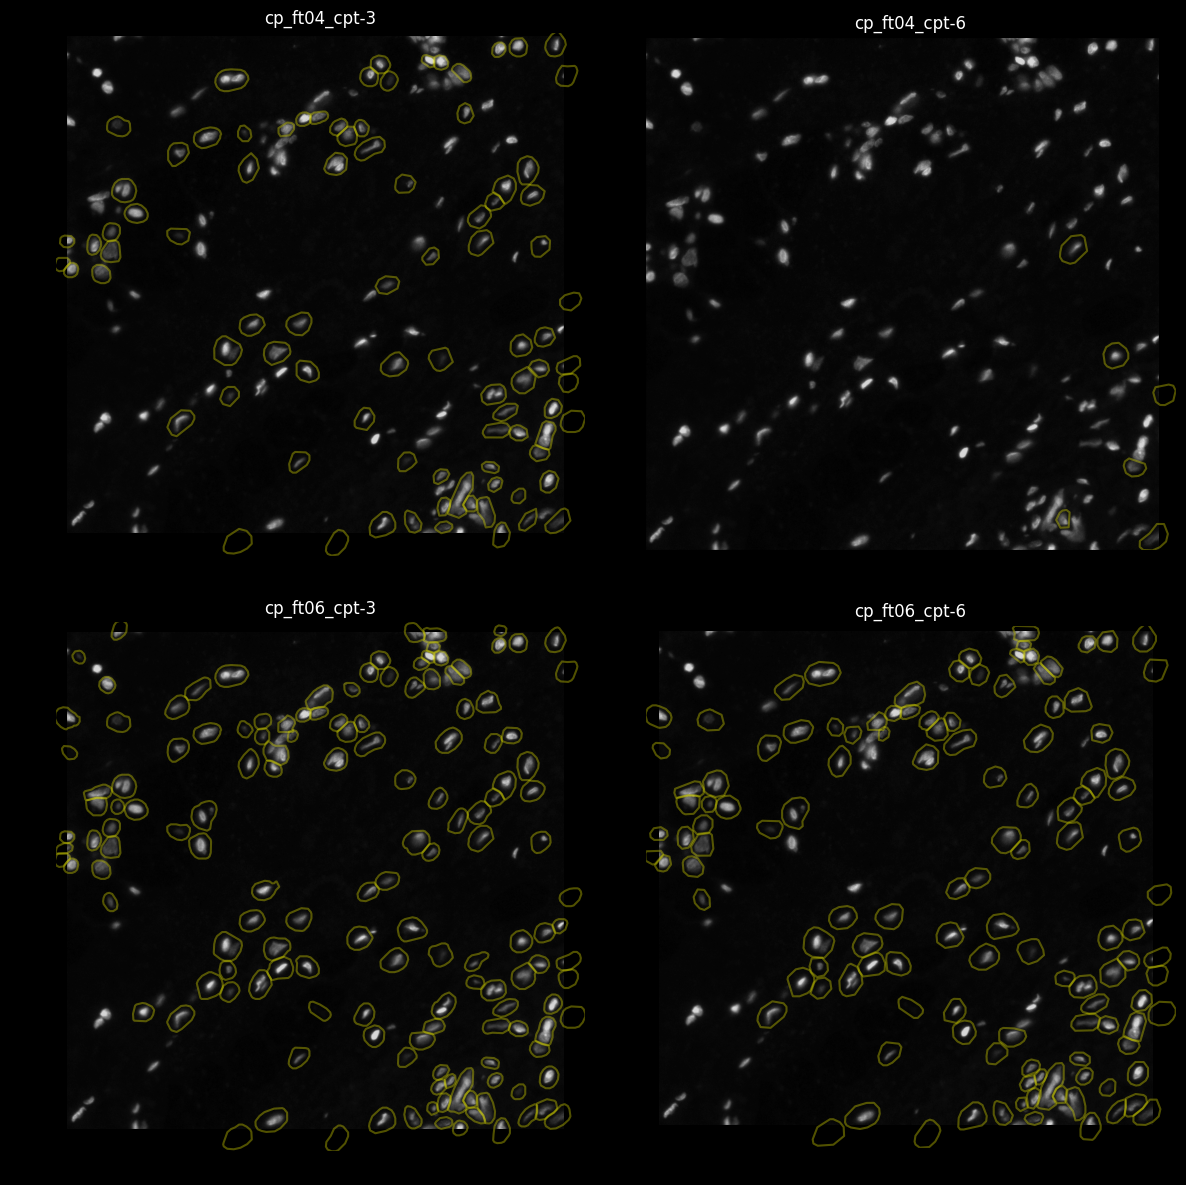

In [57]:
plot_dynamic_subplots(sdata, num_cols=2, crop=[1000, 1000, 2000, 2000], save_png="/Users/jnimoca/Jose_BI/P26_SOPA_seg/20240716_991_segopt.png")

In [72]:
flow_thresholds = [0.2, 0.8]
cellprob_thresholds = [-1, -8]
channels = ["DAPI_1"]

for ft in flow_thresholds:
    for cpt in cellprob_thresholds:
        ft_str = str(ft).replace(".", "")
        tmp_method = sopa.segmentation.methods.cellpose_patch(diameter=25, channels=channels, flow_threshold=ft, cellprob_threshold=cpt, model_type="nuclei")
        segmentation = sopa.segmentation.StainingSegmentation(sdata=sdata, method=tmp_method, channels=channels, min_area=250)
        cellpose_tmp_dir = f"./tuto_{ft_str}_{cpt}.zarr/.sopa_cache/cellpose"
        segmentation.write_patches_cells(cellpose_tmp_dir)
        cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_tmp_dir)
        cells = sopa.segmentation.shapes.solve_conflicts(cells)
        sopa.segmentation.StainingSegmentation.add_shapes(sdata=sdata, cells=cells, image_key="991_subset", shapes_key=f"cp_ft{ft_str}_cpt{str(cpt)}")

[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Reading patches: 100%|██████████| 64/64 [00:00<00:00, 547.39it/s]
[INFO] (sopa.segmentation.stainings) Found 15646 total cells
Resolving conflicts: 100%|██████████| 4980/4980 [00:00<00:00, 6100.38it/s]
[INFO] (sopa.segmentation.stainings) Added 13542 cell boundaries in sdata['cp_ft02_cpt-1']
[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Reading patches: 100%|██████████| 64/64 [00:00<00:00, 820.41it/s]
[INFO] (sopa.segmentation.stainings) Found 1 total cells
Resolving conflicts: 0it [00:00, ?it/s]
[INFO] (sopa.segmentation.stainings) Added 1 cell boundaries in sdata['cp_ft

In [79]:
sdata.write("/Users/jnimoca/Jose_BI/P26_SOPA_seg/20240716_991_segopt_2.zarr", overwrite=True)

INFO     The Zarr backing store has been changed from /Users/jnimoca/Jose_BI/P26_SOPA_seg/20240716_991_segopt.zarr 
         the new file path: /Users/jnimoca/Jose_BI/P26_SOPA_seg/20240716_991_segopt_2.zarr                         


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392156862745098..1.7137254901960786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392156862745098..1.7137254901960786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392156862745098..1.7137254901960786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392156862745098..1.7137254901960786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392156862745098..1.7137254901960786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392156862745098..1.7137254901960786].


INFO     Dropping coordinate system 'pixels' since it doesn't have relevant elements.                              
Could not render cp_ft02_cpt-8 in the specified crop area.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392156862745098..1.7137254901960786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392156862745098..1.7137254901960786].


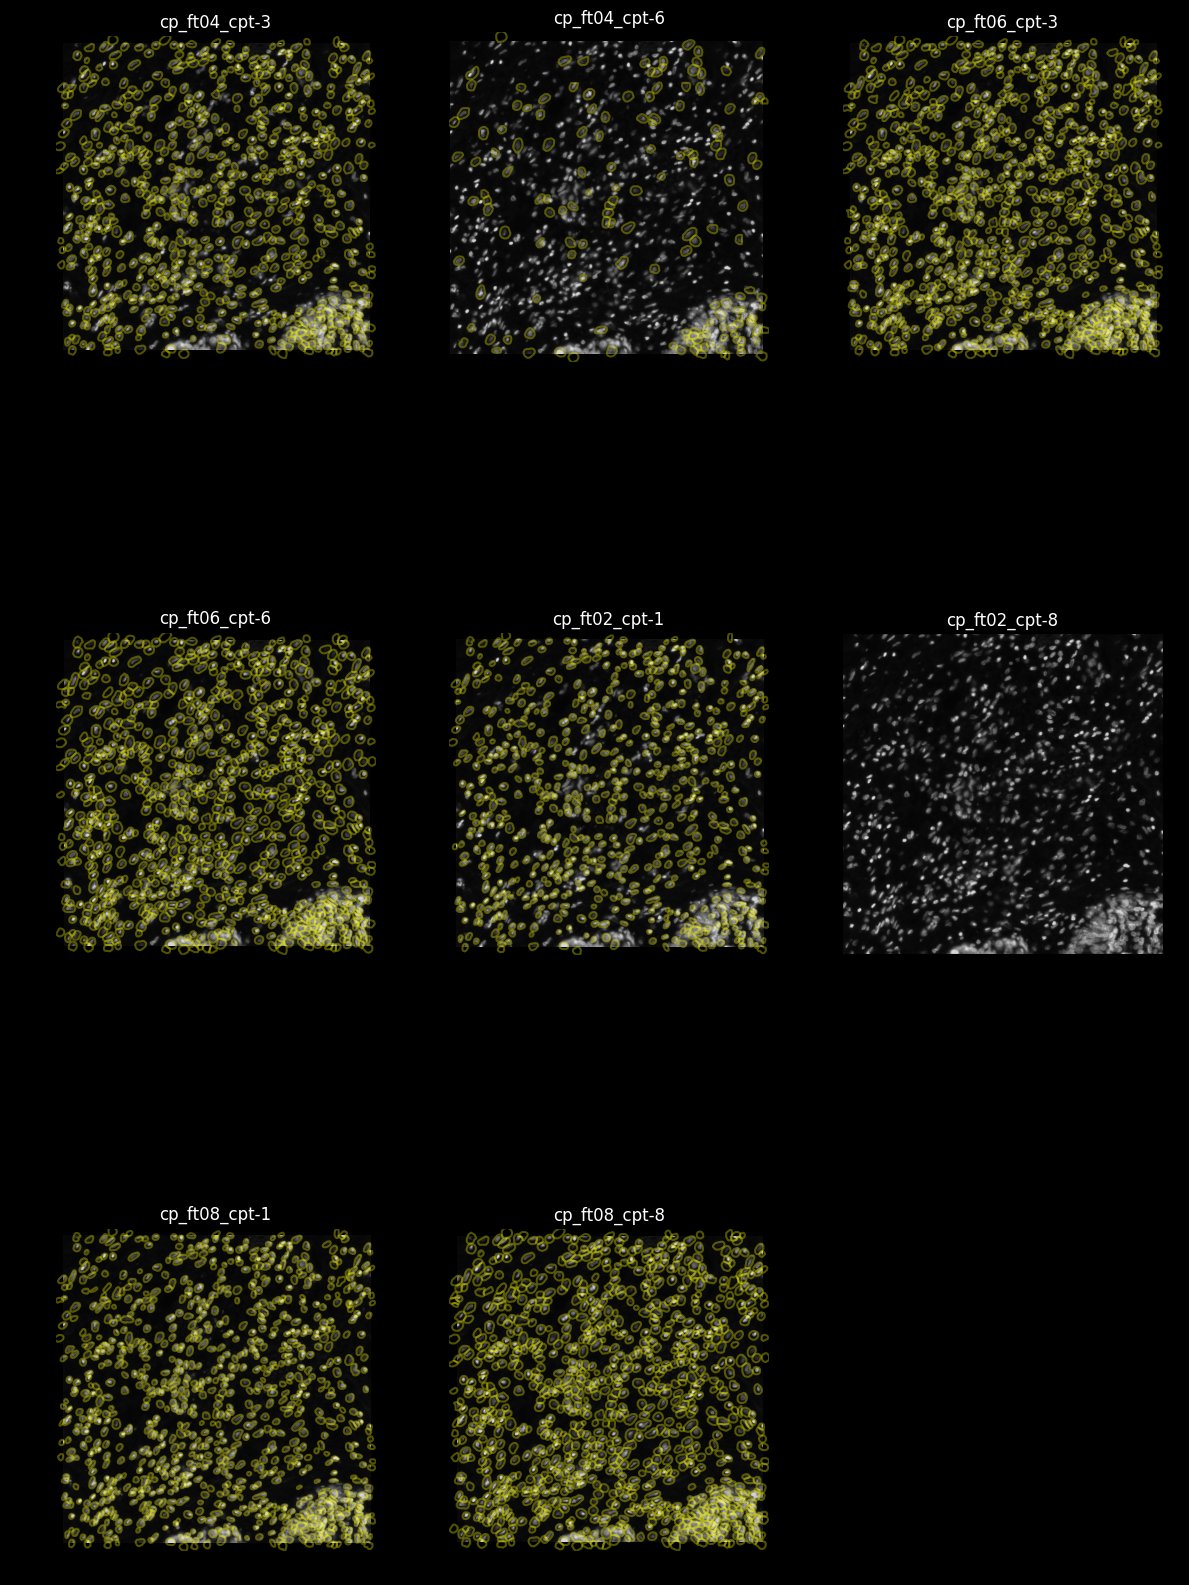

In [83]:
plot_dynamic_subplots(sdata=sdata, crop=[2000, 2000, 3500, 3500], save_png="/Users/jnimoca/Jose_BI/P26_SOPA_seg/20240716_991_segopt_2.png")

In [84]:
napari_spatialdata.Interactive(sdata)

2024-07-16 17:58:43.152 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-16 17:58:43.153 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-07-16 18:04:59.703 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-16 18:04:59.705 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-16 18:11:36.175 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-16 18:11:36.176 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-16 18:19:07.895 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-16 18:19:07.896 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-16 18:24:46.890 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating l